# Capítulo 6: Diagnóstico de supuestos

### 6.1 Linealidad y normalidad

El supuesto de **linealidad** indica que la relación entre las variables predictoras y la respuesta es aproximadamente lineal. Representado en la ecuación de regresión lineal ([Ecuación 4.1.1](#ecuacion-4-1-1)), se evalúa con un gráfico de residuales vs valores ajustados; una dispersión aleatoria alrededor de cero sin patrones sugiere que se cumple, desviaciones sugieren una relación no lineal o la necesidad de alguna transformación.

La **normalidad de los residuos** implica que $\varepsilon \sim N(0, \sigma^2)$
**Ecuación 6.1.1.** Normalidad de los residuos.

Se verifica con un QQ-plot, comparando los residuos con los cuantiles teóricos de una normal. Si los puntos siguen la línea, el supuesto se cumple; desviaciones pueden afectar la validez de intervalos y pruebas de hipótesis.


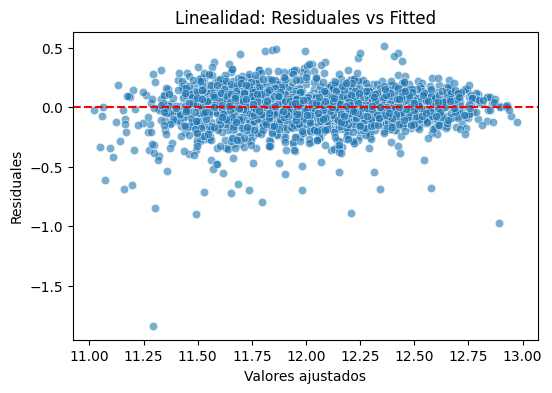

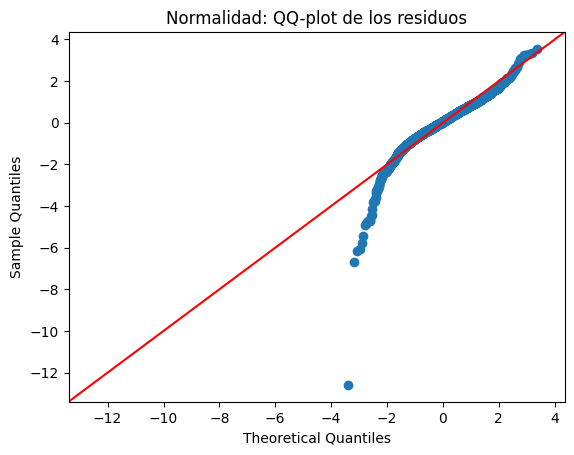

In [16]:
import pandas as pd
import statsmodels.api as sm

data_modelo_final = pd.read_csv("../data/AmesHousing_sin_outliers.csv")
data_modelo_final = data_modelo_final[
    ['SalePrice_log', 'Overall Qual', 'Gr Liv Area', 'Garage Cars',
     'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'Year Built',
     'Fireplaces', 'Lot Area']
]

X = data_modelo_final[
    ['Overall Qual', 'Gr Liv Area', 'Garage Cars',
     'Total Bsmt SF', '1st Flr SF', 'Full Bath',
     'Year Built', 'Fireplaces', 'Lot Area']
]
y = data_modelo_final[['SalePrice_log']]

X = sm.add_constant(X)

modelo_final = sm.OLS(y, X)
resultados = modelo_final.fit()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

plt.figure(figsize=(6,4))
sns.scatterplot(x=resultados.fittedvalues, y=resultados.resid, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Linealidad: Residuales vs Fitted")
plt.xlabel("Valores ajustados")
plt.ylabel("Residuales")
plt.show()

sm.qqplot(resultados.resid, line="45", fit=True)
plt.title("Normalidad: QQ-plot de los residuos")
plt.show()

**Figura 6.1.1.** Linealidad y normalidad del modelo 1.

En cuanto a la linealidad, la mayoría de los residuales se distribuyen de manera aleatoria alrededor de 0, lo que indica que el modelo captura correctamente la tendencia general. Sin embargo, se observan algunos valores extremos a lo largo del eje x, incluyendo un residual notablemente por debajo de los demás.  

El QQ-plot muestra que a partir de aproximadamente -2 los datos siguen de manera bastante cercana la línea de referencia. Para valores menores a -2, los residuales se curvan hacia abajo y se desvían de la línea, lo que sugiere cierta no normalidad en los extremos. Esto puede afectar la validez de los intervalos de confianza y de las pruebas de significancia, aunque el ajuste de los coeficientes sigue siendo consistente bajo mínimos cuadrados.


### 6.2 Homocedasticidad, autocorrelación y multicolinealidad

La **homocedasticidad** indica que la varianza de los errores debe ser constante a lo largo de todos los valores de las variables predictoras. Se suele evaluar mediante pruebas como Breusch–Pagan o White. Su incumplimiento puede conducir a errores estándar incorrectos y, por lo tanto, a inferencias poco confiables sobre los coeficientes. Matemáticamente, se espera que:

$$
\text{Var}(\varepsilon_i) = \sigma^2, \quad \forall i
$$

La **autocorrelación** implica que los errores de observaciones consecutivas no deben estar correlacionados. Se interpreta a menudo con la estadística de Durbin–Watson, donde valores cercanos a 2 indican ausencia de autocorrelación. La presencia de autocorrelación puede inflar la significancia aparente de los coeficientes y afectar la precisión de las predicciones. Formalmente:

$$
\text{Cov}(\varepsilon_i, \varepsilon_j) = 0, \quad i \neq j
$$

La **multicolinealidad** ocurre cuando dos o más predictores están fuertemente correlacionados, dificultando estimar sus efectos individuales. Se puede observar usando la **matriz de correlaciones** de los predictores.

$$
r_{jk} = \frac{\text{Cov}(X_j, X_k)}{\sigma_{X_j} \, \sigma_{X_k}}
$$

Valores $\left| r_{jk} \right|$ cercanos a 1 indican fuerte correlación, es decir, posible multicolinealidad. Además, se puede cuantificar mediante el **VIF (Variance Inflation Factor)**; un VIF mayor a 5 suele indicar una correlación problemática.


In [17]:
bp_test = sms.het_breuschpagan(resultados.resid, resultados.model.exog)
white_test = sms.het_white(resultados.resid, resultados.model.exog)
bp_pvalue = bp_test[1]
white_pvalue = white_test[1]

dw = sm.stats.stattools.durbin_watson(resultados.resid)

vif_data = pd.DataFrame()
vif_data["Variable"] = resultados.model.exog_names
vif_data["VIF"] = [variance_inflation_factor(resultados.model.exog, i) 
                   for i in range(resultados.model.exog.shape[1])]

tabla_supuestos = pd.DataFrame({
    "Supuesto": ["Homocedasticidad", "Autocorrelación", "Multicolinealidad"],
    "Método": [
        "Breusch–Pagan / White",
        "Durbin–Watson",
        "VIF"
    ],
    "Valor observado": [
        f"BP p={bp_pvalue:.4f}, White p={white_pvalue:.4f}",
        f"DW={dw:.2f}",
        "; ".join([f"{vif_data['Variable'][i]}: {vif_data['VIF'][i]:.2f}" for i in range(len(vif_data))])
    ],
    "Interpretación esperada": [
        "p > 0.05 → no heterocedasticidad",
        "~2 → no autocorrelación",
        "<5 → aceptable"
    ]
})

tabla_supuestos


,Supuesto,Método,Valor observado,Interpretación esperada
0,Homocedasticidad,Breusch–Pagan / White,"BP p=0.0000, White p=0.0000",p > 0.05 → no heterocedasticidad
1,Autocorrelación,Durbin–Watson,DW=1.79,~2 → no autocorrelación
2,Multicolinealidad,VIF,const: 8331.78; Overall Qual: 2.58; Gr Liv Are...,<5 → aceptable


**Figura 6.1.2.** Homocedasticidad, autocorrelación y multicolinealidad del modelo 1.

Los resultados de las pruebas de Breusch–Pagan y White muestran valores p iguales a 0.0000, indicando evidencia clara de heterocedasticidad. Esto significa que la variabilidad de los residuos no es constante a lo largo de los valores ajustados, lo cual podría afectar la confiabilidad de los intervalos de confianza y los errores estándar.

El estadístico de Durbin–Watson es 1.79, lo que se encuentra dentro del rango de 1.5 a 2. Por lo tanto, no se observa autocorrelación significativa entre los residuos, y el supuesto de independencia se cumple razonablemente.

Con respecto a la multicolinealidad, todos los valores de VIF de los predictores son menores a 5, lo que indica que no hay problemas importantes de colinealidad en el modelo.